In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  confusion_matrix, precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
from matplotlib import pyplot as plt
import pandas as pd
import gensim
import seaborn as sns

In [2]:
stemmer = PorterStemmer()
stop = stopwords.words('english')

In [3]:
# Evaluation Metrics
def print_results(y_test,predicted,predicted_prob):
    classes = np.unique(y_test)
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob, 
                                multi_class="ovr")
    print("Accuracy:",  round(accuracy,2))
    print("Area Under The Curve:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    make_confusion_matrix(cf=cm,figsize=(8,5))

    
# https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
# Draws the confusion matrix in a very nice way
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title="Confusion Matrix"):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [4]:
df = pd.read_csv("comments_all.csv").dropna()


Accuracy: 0.73
Area Under The Curve: 0.82
Detail:
              precision    recall  f1-score   support

          -1       0.71      0.95      0.82    223018
           0       0.74      0.31      0.44     73734
           1       0.83      0.46      0.59     73575

    accuracy                           0.73    370327
   macro avg       0.76      0.57      0.61    370327
weighted avg       0.74      0.73      0.70    370327



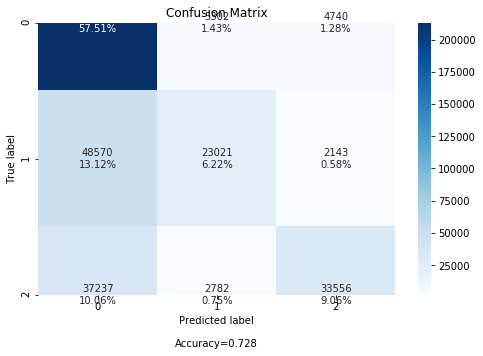

In [8]:
X = df['comment']
Y = df['stance']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=10)
clf_1 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.1, min_df= 0,strip_accents= 'unicode',lowercase=True)),
                 ('NB_clf',MultinomialNB(alpha=0.1))])


clf_1 = clf_1.fit(X_train, y_train)

pred = clf_1.predict(X_test)
pred_proba = clf_1.predict_proba(X_test)
print_results(y_test,pred,pred_proba)

Accuracy: 0.76
Area Under The Curve: 0.84
Detail:
              precision    recall  f1-score   support

          -1       0.74      0.96      0.84    223018
           0       0.75      0.36      0.49     73734
           1       0.83      0.54      0.66     73575

    accuracy                           0.76    370327
   macro avg       0.77      0.62      0.66    370327
weighted avg       0.76      0.76      0.73    370327



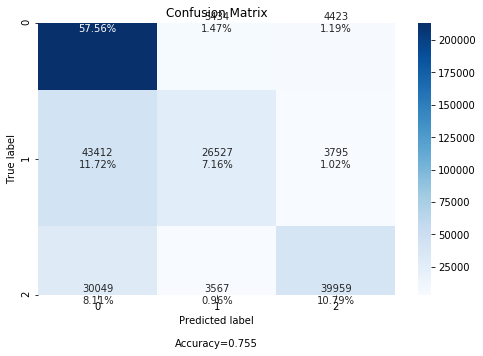

In [9]:
X = df['comment']+df['Topic']
Y = df['stance']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=10)
clf_1 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.1, min_df= 0,strip_accents= 'unicode',lowercase=True)),
                 ('NB_clf',MultinomialNB(alpha=0.1))])


clf_1 = clf_1.fit(X_train, y_train)

pred = clf_1.predict(X_test)
pred_proba = clf_1.predict_proba(X_test)
print_results(y_test,pred,pred_proba)

Accuracy: 0.77
Area Under The Curve: 0.85
Detail:
              precision    recall  f1-score   support

          -1       0.77      0.95      0.85    223018
           0       0.74      0.39      0.51     73734
           1       0.82      0.60      0.69     73575

    accuracy                           0.77    370327
   macro avg       0.77      0.65      0.69    370327
weighted avg       0.77      0.77      0.75    370327



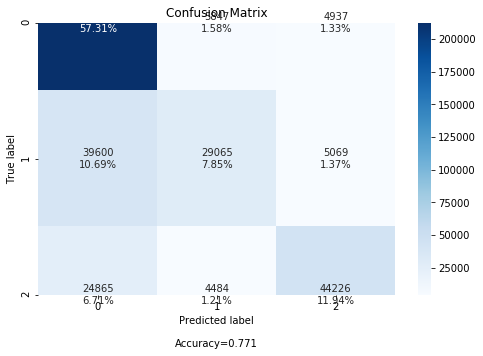

In [10]:
import re
def remove_digits(string):
    return re.sub('[^a-zA-Z]', ' ', string )

def remove_special_chars(string):
    return re.sub(r'\s+', ' ', string)

df['comments'] = df['comment'].apply(remove_digits)
df['comments'] = df['comments'].apply(remove_special_chars)
df['comments'] = df['comments'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

X = df['comments']+df['Topic']
Y = df['stance']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=10)
clf_1 = Pipeline([('tfidf', TfidfVectorizer(max_df=0.1, min_df= 0,strip_accents= 'unicode',lowercase=True)),
                 ('NB_clf',MultinomialNB(alpha=0.1))])


clf_1 = clf_1.fit(X_train, y_train)

pred = clf_1.predict(X_test)
pred_proba = clf_1.predict_proba(X_test)
print_results(y_test,pred,pred_proba)